# Classification Example
Latent Dimensionality Reduction applied to the [Wisconsin breat cancer data set](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html).

In [5]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn import svm
from sklearn.neighbors import KernelDensity

from ..ldr import LDR

ValueError: attempted relative import beyond top-level package

In [ ]:
plt.style.use("ekrekr.mplstyle")

In [ ]:
WRITE_PATH = "write_up/img/"

## Preprocessing

Load dataset. The breast cancer data set is used as it has a good number of samples for model training, and a number of dimensions that will result in a significantly difficult to interpret model.

In [ ]:
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["species"] = pd.Categorical.from_codes(data.target, data.target_names)
print(df["species"].value_counts())
print("Shape:", df.shape)
df.head()

In [5]:
pos = df[df["species"] == "malignant"]
neg = df[df["species"] == "benign"]
print(neg.shape, pos.shape)

(357, 31) (212, 31)


Drop species as this is the target.

In [6]:
targets = df["species"]
df = df.drop(["species"], axis=1)

Scale the data.

In [7]:
ldr = LDR(df, targets, "class", "benign", "malignant")

Class balance fixed, Negatives: 357 , Positives: 357


In [8]:
# Train classifier and check accuracy.
X_train, X_test, y_train, y_test = train_test_split(
    ldr.scaled, ldr.targets, test_size=0.3, random_state=42)

Define features to visualize.

In [9]:
features = ["mean area", "mean symmetry", "smoothness error"]
# features = ["mean area", "mean symmetry"]

## Classifier Training and Analysis

### Random Forests

In [10]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)
preds = rf_clf.predict(X_test)
print("F1 score:", f1_score(y_test, preds, pos_label="malignant"))
print("Confusion matrix:")
print(confusion_matrix(y_test, preds))

F1 score: 0.9593495934959351
Confusion matrix:
[[107   1]
 [  4  59]]


In [11]:
def rf_clf_func(df):
    proba = rf_clf.predict_proba(df)
    return np.array([i[1] for i in proba])

### Isolation Forest
Used for outlier detection/estimating a learning frontier.

In [12]:
oc_clf = IsolationForest(n_estimators=100, behaviour="new", contamination="auto").fit(X_train)

In [13]:
def oc_clf_func(df):
    pred = oc_clf.predict(df)
    return [(i + 1) / 2 for i in pred]

In [14]:
tst = oc_clf_func(X_train)
pd.Series(tst).value_counts()

1.0    365
0.0     33
dtype: int64

## Random Forest Classifier and Outlier Detection Superposition

In [15]:
def oc_rf_clf_func(df):
    oc_pred = oc_clf_func(df)
    rf_pred = rf_clf_func(df)
    return [(rf_pred[i] - 0.5) * i_val + 0.5 for i, i_val in enumerate(oc_pred)]

In [16]:
tst = oc_rf_clf_func(X_train[:30])
print(tst[:30])

[0.010000000000000009, 0.010000000000000009, 0.20999999999999996, 0.0, 0.0, 0.79, 0.030000000000000027, 0.0, 0.07, 0.0, 0.06, 0.010000000000000009, 0.95, 1.0, 0.96, 0.17000000000000004, 0.020000000000000018, 0.95, 0.030000000000000027, 1.0, 0.0, 0.0, 0.0, 0.0, 0.95, 0.020000000000000018, 0.0, 0.5, 0.010000000000000009, 0.030000000000000027]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


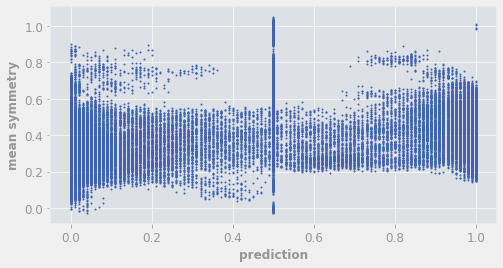

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


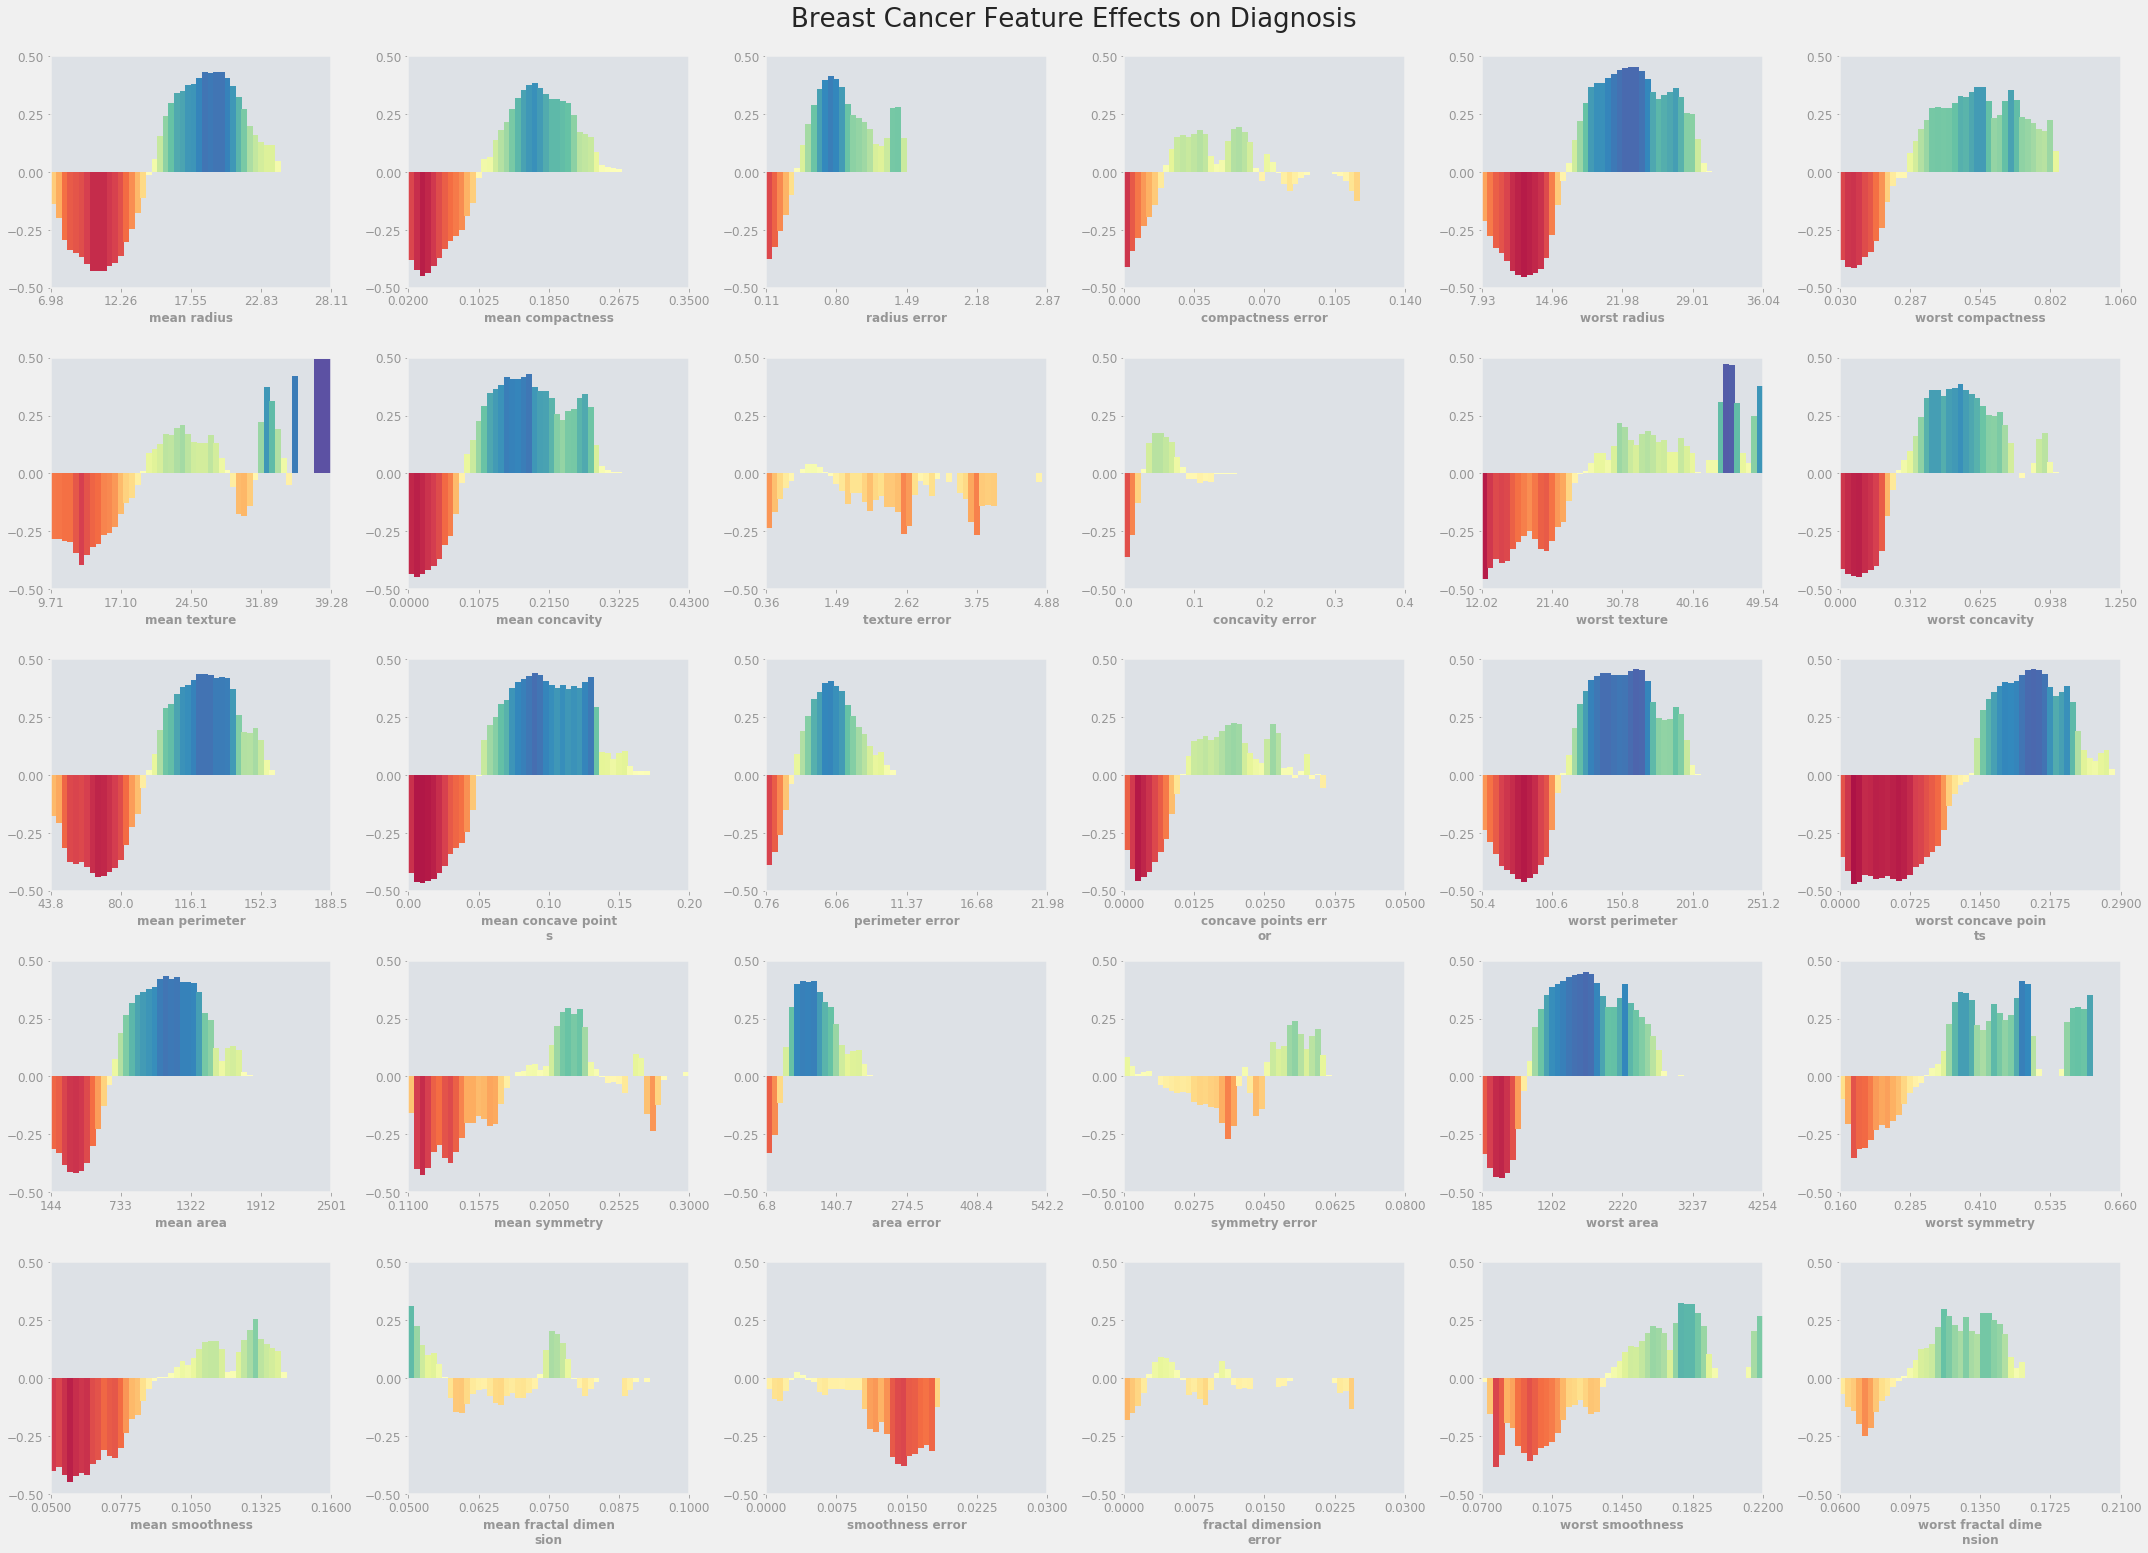

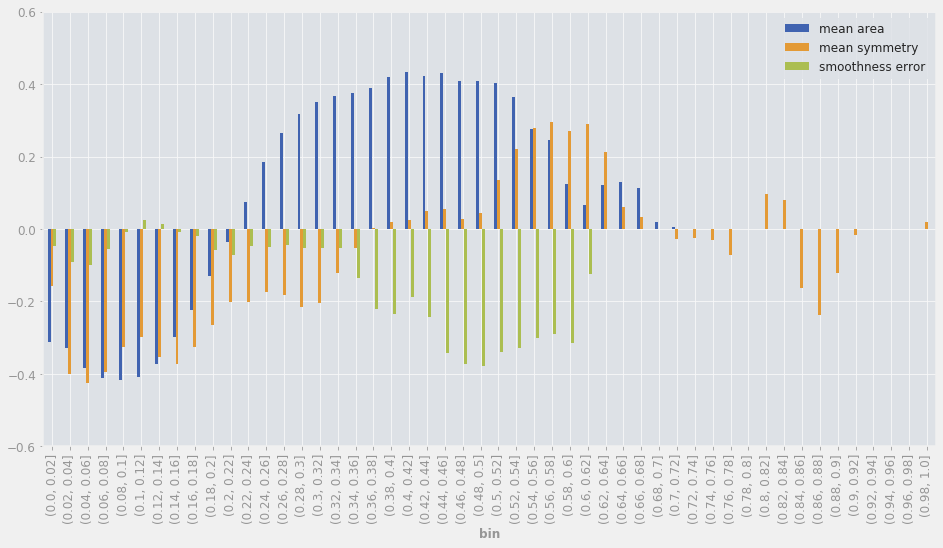

TL: [(2, 1), (1, 1), (1, 2)]
BR: [(2, 2)]
LR: [(0, 1), (0, 2)]
TR: [(1, 0), (2, 0)]
2 1
mean symmetry smoothness error
1 1
mean area smoothness error
1 2
mean area mean symmetry


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


1 0
mean area
2 0
mean symmetry
0 1
smoothness error
0 2
mean symmetry


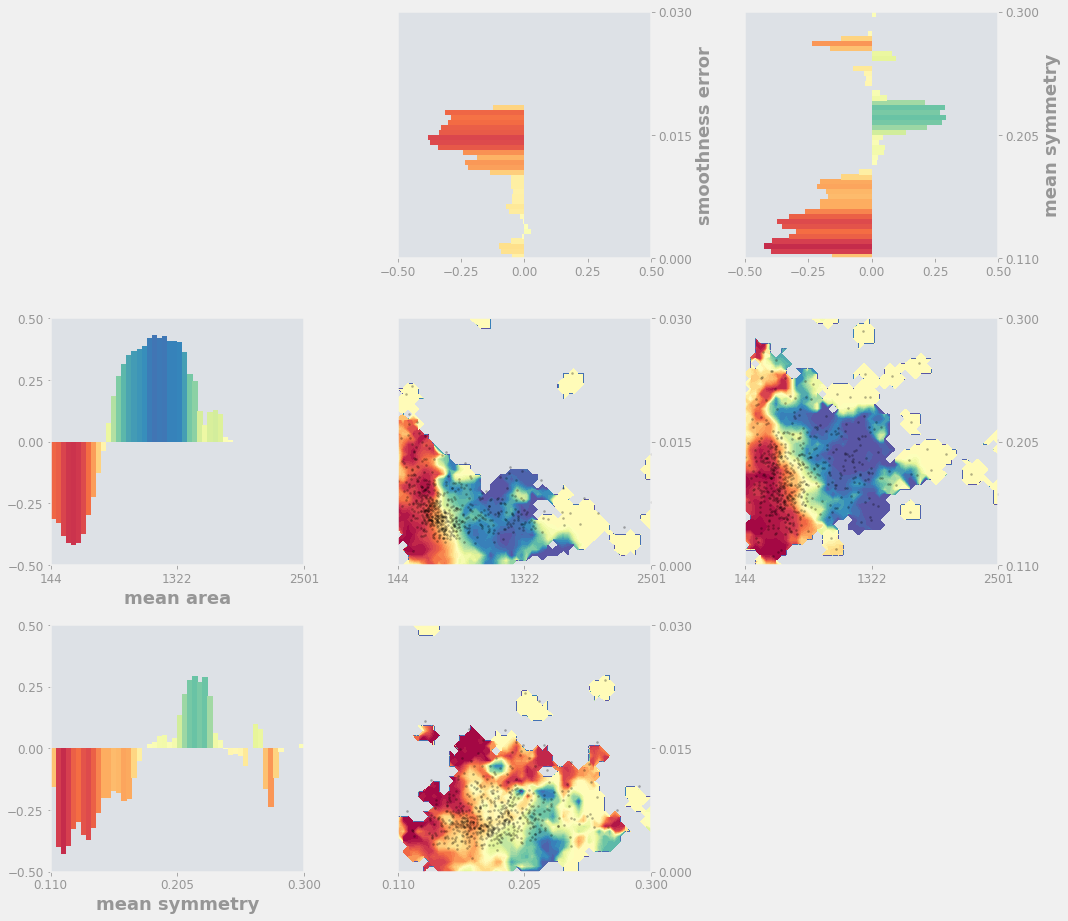

In [17]:
ldr.density_estimate(oc_rf_clf_func)
ldr.density_scatter(features[1], save=WRITE_PATH + "rf_if_mean_symmetry.png")
ldr.vis_1d_separate("Breast Cancer Feature Effects on Diagnosis")
ldr.select_bins(features)
ldr.vis_1d()
ldr.vis_2d(save=WRITE_PATH + "rf_if_matrix.png")

The areas where the classifier is uncertain have been superposed with the areas where samples are taken where training data is not present. The dark colours are strong indicators of malignancy accross dimensions.

## Neural Network

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 30 dimensions go in, 2 go out. The 2 coming out are the two
        # different classes available.
        self.fc1 = nn.Linear(X_train.shape[1], 3)
        self.fc2 = nn.Linear(3, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        return x

    def predict(self, x):
        # Calculate probabilities of each class.
        pred = F.softmax(self.forward(x))
        
        # Return the largest weighted class.
        return torch.tensor([0 if i[0] > i[1] else 1 for i in pred])
    
    def predict_proba(self, x):
        # Calculate probabilities of each class.
        pred = F.softmax(self.forward(x))
        
        # Return the largest weighted class.
        return torch.tensor([i[1] / (i[0] + i[1]) for i in pred])

This may need to be rerun to prevent the stochastic trap.

In [19]:
net = Net()

# Prepare data for neural network.
inputs = torch.FloatTensor(X_train.values)
labels = torch.LongTensor([1 if i == "malignant" else 0 for i in y_train])

# Optimizer to speed things up, cross entropy loss as it is a classifcation problem.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
epochs = 50000

losses = []
for epoch in range(epochs):
    outputs = net.forward(inputs)
    loss = criterion(outputs, labels)
    losses.append(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print("epoch:", epoch, "loss:", loss)
    
print('Finished Training ')

/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch: 0 loss: tensor(0.6685, grad_fn=<NllLossBackward>)
epoch: 1000 loss: tensor(0.0164, grad_fn=<NllLossBackward>)
epoch: 2000 loss: tensor(0.0032, grad_fn=<NllLossBackward>)
epoch: 3000 loss: tensor(0.0011, grad_fn=<NllLossBackward>)
epoch: 4000 loss: tensor(0.0005, grad_fn=<NllLossBackward>)
epoch: 5000 loss: tensor(0.0002, grad_fn=<NllLossBackward>)
epoch: 6000 loss: tensor(0.0001, grad_fn=<NllLossBackward>)
epoch: 7000 loss: tensor(6.4426e-05, grad_fn=<NllLossBackward>)
epoch: 8000 loss: tensor(3.5927e-05, grad_fn=<NllLossBackward>)
epoch: 9000 loss: tensor(2.0316e-05, grad_fn=<NllLossBackward>)
epoch: 10000 loss: tensor(1.1637e-05, grad_fn=<NllLossBackward>)
epoch: 11000 loss: tensor(6.7366e-06, grad_fn=<NllLossBackward>)
epoch: 12000 loss: tensor(3.9301e-06, grad_fn=<NllLossBackward>)
epoch: 13000 loss: tensor(2.3068e-06, grad_fn=<NllLossBackward>)
epoch: 14000 loss: tensor(1.3598e-06, grad_fn=<NllLossBackward>)
epoch: 15000 loss: tensor(8.0660e-07, grad_fn=<NllLossBackward>)
e

Test NN accuracy.

In [20]:
test_input = torch.FloatTensor(X_test.values)
preds = np.array(net.predict(test_input))
test_labels = [1 if i == "malignant" else 0 for i in y_test]
print(preds)
print("F1 score:", f1_score(test_labels, preds, pos_label=1))
print("Confusion matrix:")
print(confusion_matrix(test_labels, preds))

[0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 1 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0 0 1 1 0 1
 0 0 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 1 0 0 1
 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1
 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0]
F1 score: 0.9457364341085271
Confusion matrix:
[[103   5]
 [  2  61]]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


The actual classifier function uses the raw certainty of the model.

In [21]:
def nn_clf_func(df):
    test_tensor = torch.FloatTensor(df.values)
    return np.array(net.predict_proba(test_tensor))

## NN Classifier and Outlier Detection Interpolation

In [22]:
def oc_nn_clf_func(df):
    oc_pred = oc_clf_func(df)
    nn_pred = nn_clf_func(df)
    return [(nn_pred[i] - 0.5) * i_val + 0.5 for i, i_val in enumerate(oc_pred)]

In [23]:
tst = oc_nn_clf_func(X_train)
print(tst[:30])

[0.0, 0.0, 1.2378986724570495e-14, 0.0, 4.490852134608758e-14, 1.0, 0.0, 0.0, 2.842170943040401e-14, 1.1102230246251565e-16, 1.0819233287051588e-09, 0.0, 1.0, 1.0, 1.0, 1.4864264263891869e-09, 3.003527426770347e-10, 1.0, 3.2174263253637037e-13, 1.0, 0.0, 0.0, 0.0, 3.4983682617450995e-12, 1.0, 5.627085908344043e-09, 0.0, 0.5, 0.0, 0.0]


/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


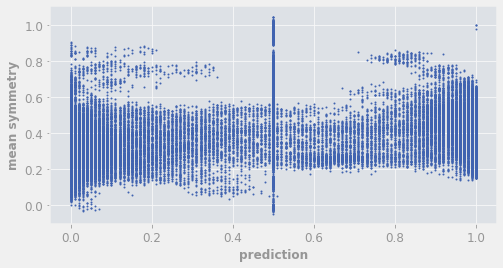

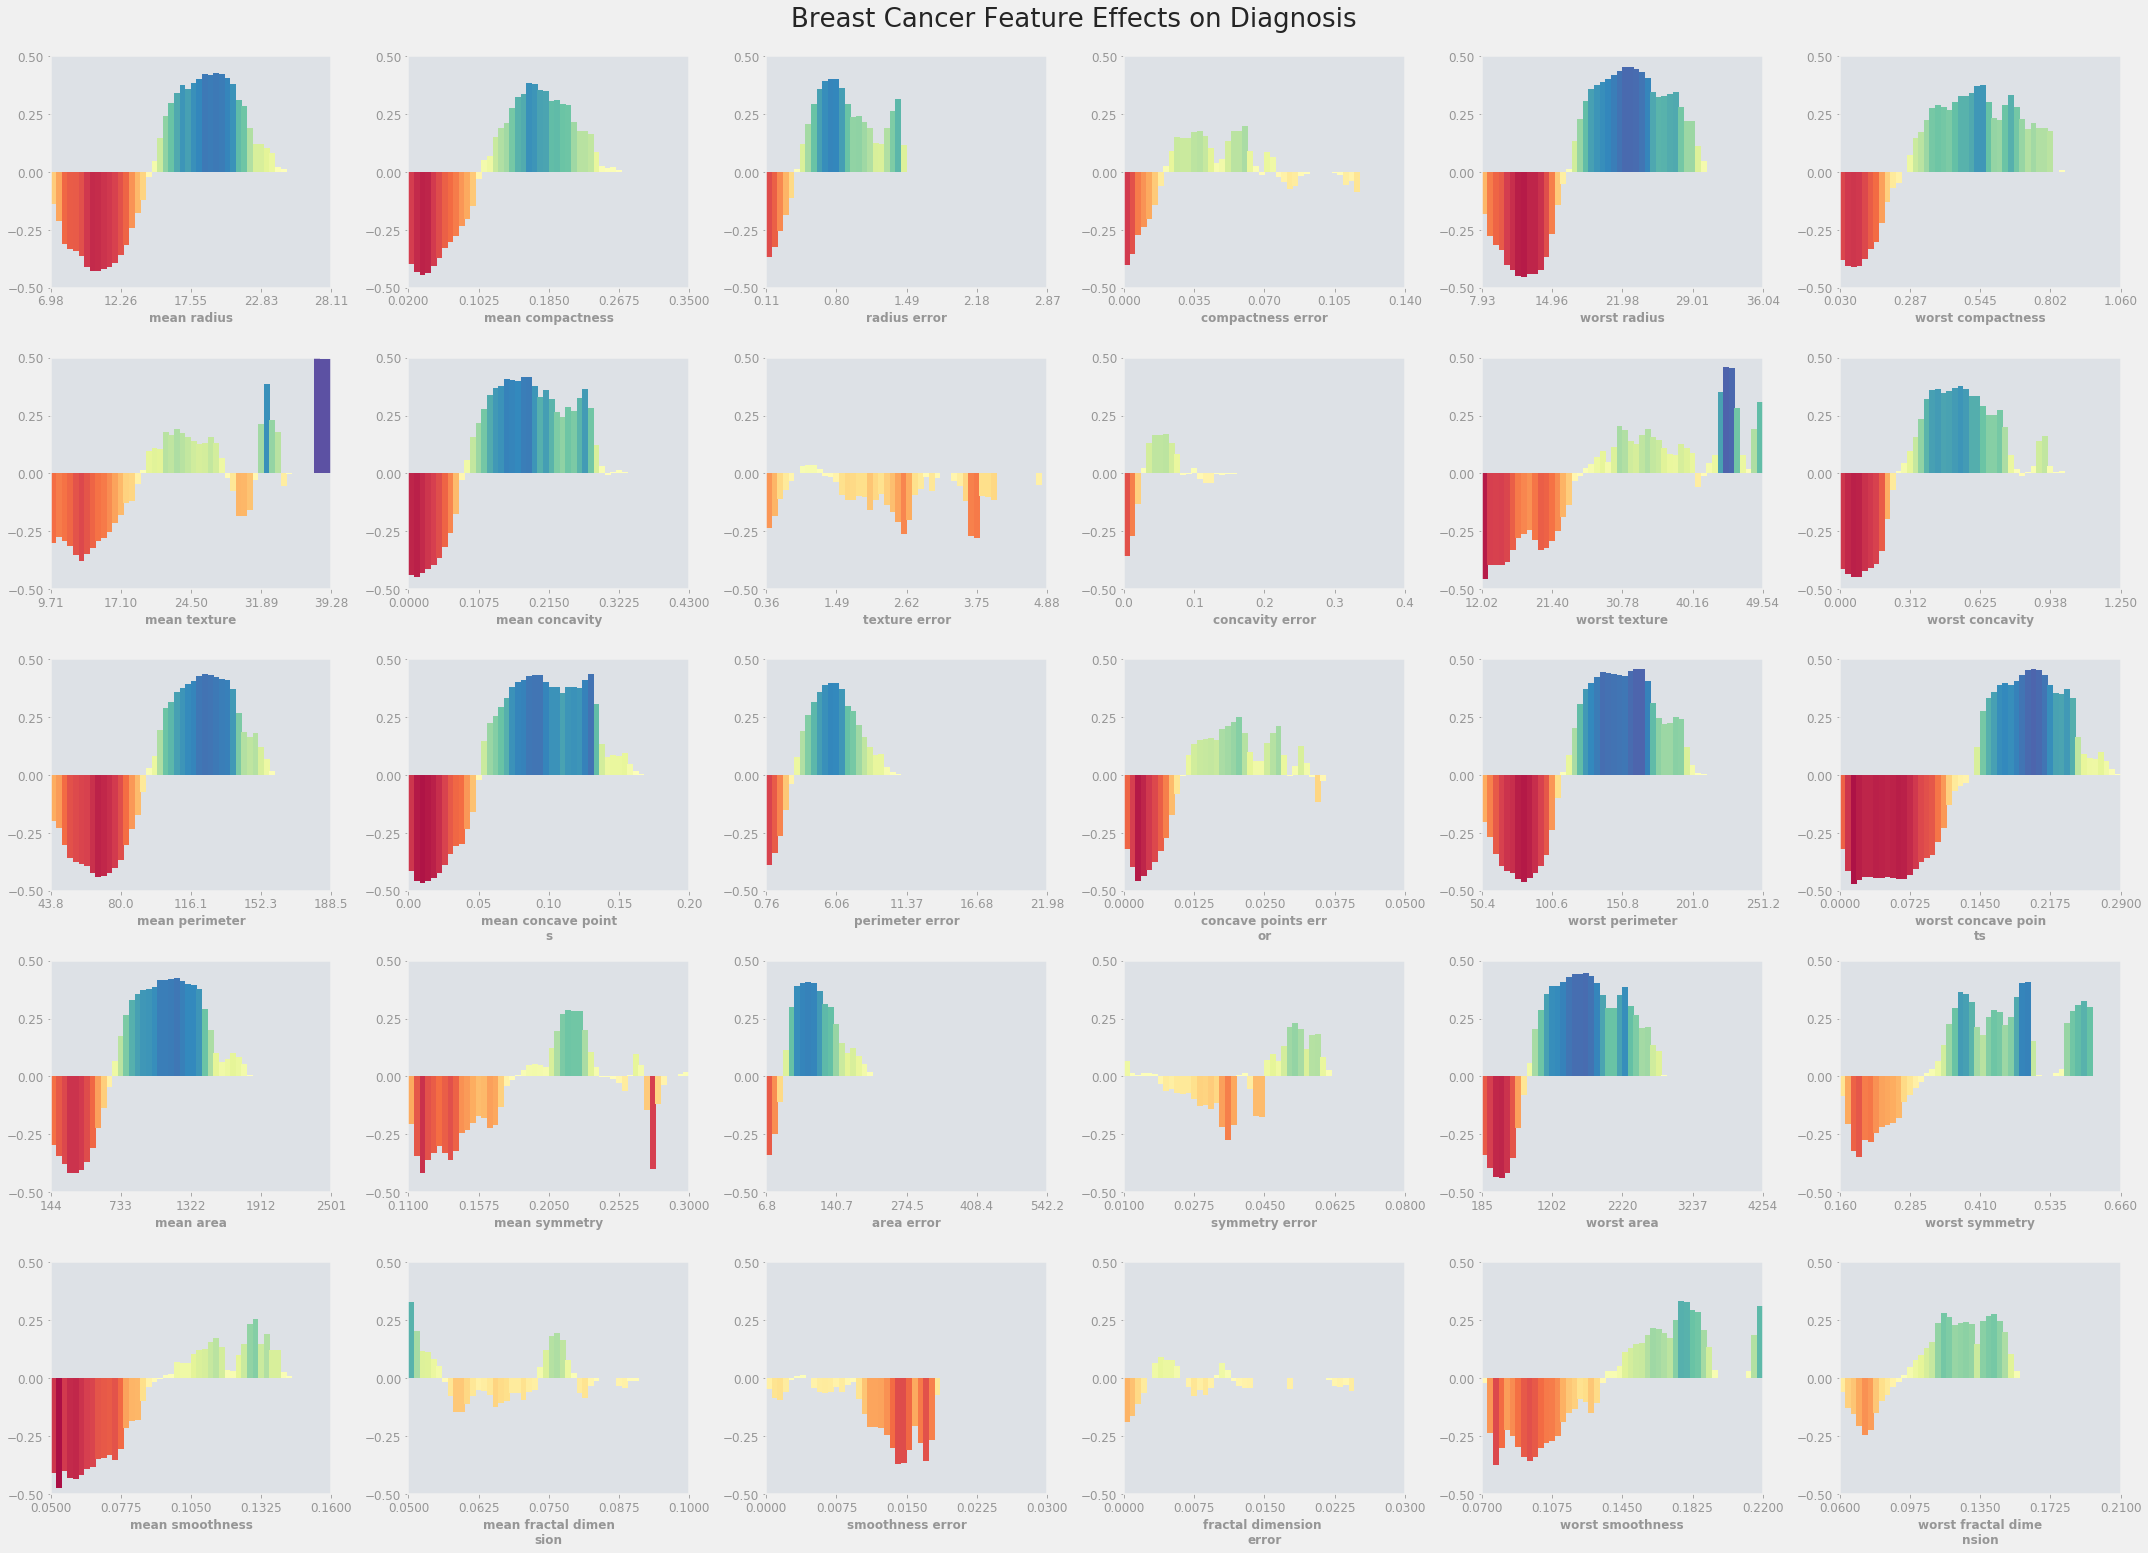

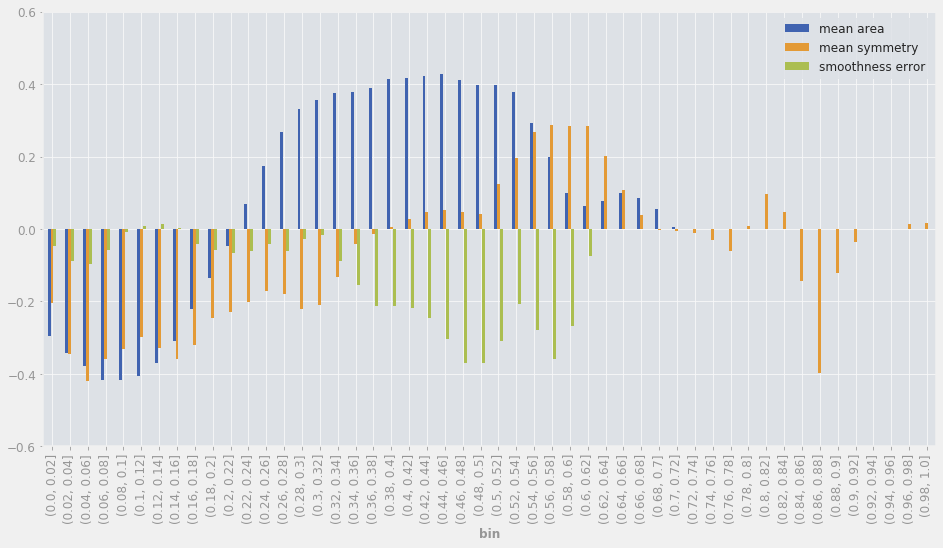

TL: [(2, 1), (1, 1), (1, 2)]
BR: [(2, 2)]
LR: [(0, 1), (0, 2)]
TR: [(1, 0), (2, 0)]
2 1
mean symmetry smoothness error
1 1
mean area smoothness error
1 2
mean area mean symmetry
1 0
mean area
2 0
mean symmetry
0 1
smoothness error
0 2
mean symmetry


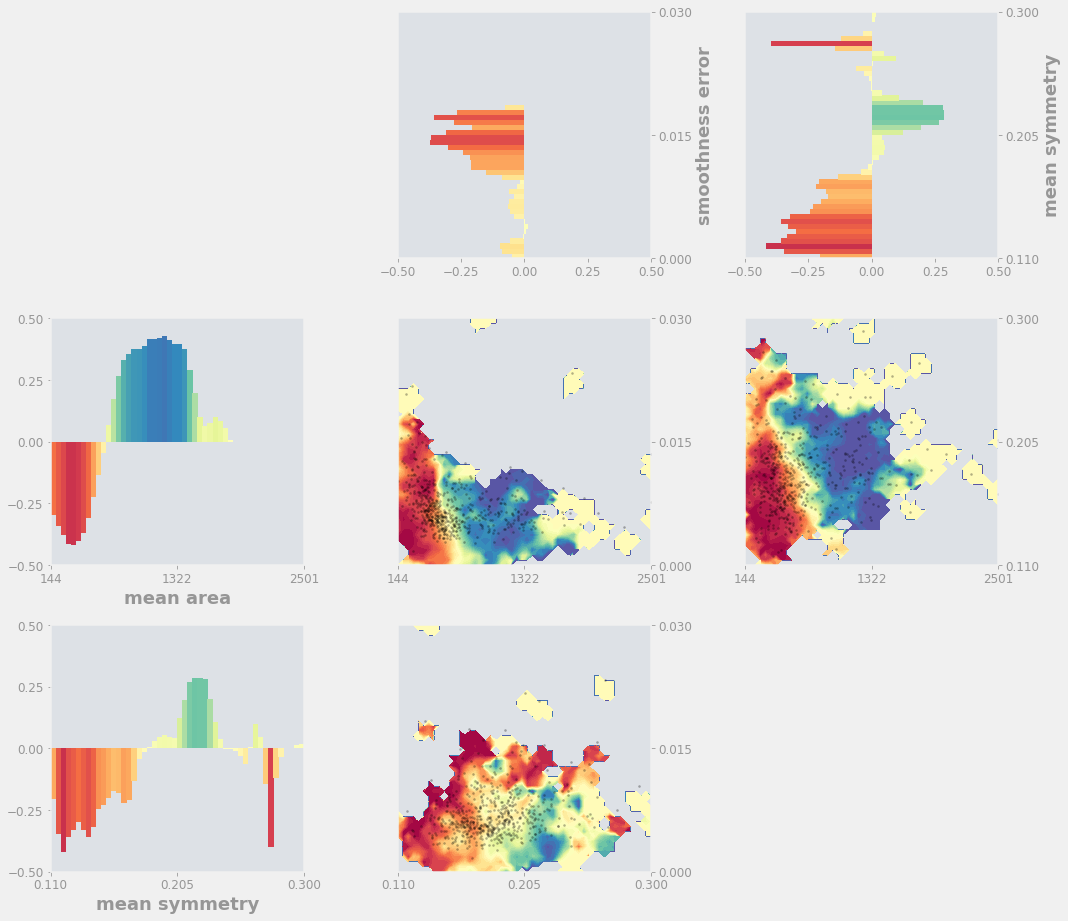

In [24]:
ldr.density_estimate(oc_rf_clf_func)
ldr.density_scatter(features[1], save=WRITE_PATH + "nn_if_mean_symmetry.png")
ldr.vis_1d_separate("Breast Cancer Feature Effects on Diagnosis")
ldr.select_bins(features)
ldr.vis_1d()
ldr.vis_2d(save=WRITE_PATH + "nn_if_matrix.png")